In [128]:
import numpy as np
from scipy import optimize
import os
import subprocess
from contextlib import contextmanager
import time
import matplotlib.pyplot as plt
import math

First, we'll read in the files created by the Fortran HF code. Things are a little messy thanks to the way I stored things in the past, but they are standard numpy arrays after this cell. Take note of the ordering and suggest a more agreeable choice if you've got an opinion.

In [277]:
@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def spin(spin):
    if(spin==1): return -0.5
    return 0.5

def make_input(params,restart):
    in_template = "../HF/in.template"
    f1 = open(in_template, 'r')
    
    int_string = "&interaction t0={t0},x0={x0},t1={t1},x1={x1},t2={t2},x2={x2},t3={t3},x3={x3},w0={w0},sig={sig},icoul=1,icm=1,j2terms=.true. / \n".format(\
    t0=params["t0"],x0=params["x0"],t1=params["t1"],x1=params["x1"],t2=params["t2"],x2=params["x2"],t3=params["t3"],x3=params["x3"],w0=params["w0"],sig=params["sig"])
    if(restart):
        io_string = "&io printwf=F,printdens=F,restartwf=T,printhpsi=T /"
    else:
        io_string = "&io printwf=T,printdens=F,restartwf=F,printhpsi=F /"
    in_out = "../HF/in"
    f2 = open(in_out, 'w')
    f1.seek(0)
    f2.write(f1.read())
    f2.write(int_string)
    f2.write(io_string)
    f2.write("\n")

    f1.close()
    f2.close()

    return

def run_HF(tag,restart):
    noNaN = 1
    neut = 0
    if(restart == 0):
        os.system("cp in results/in."+tag)
        #print(os.system("../HF/./main"))
        output = subprocess.run(["./main"], capture_output=True)
        #print(output)
        #print(subprocess.run("../HF/./main",shell=True))
        os.system("mv out results/out."+tag)
        os.system("mv wf_numpy.bin results/wf_numpy.bin."+tag)
        noNaN = os.system("grep -q NaN results/out."+tag)
        neut = os.system('grep -q "Total Neutrons =   28.000" results/out.'+tag)
        neut = neut+os.system('grep -q "Total Neutrons =   27.999" results/out.'+tag)
    else:
        output = subprocess.run(["./main"], capture_output=True)
        #os.system("mv out results/out_rst."+tag)
        #os.system("mv hpsi.bin results/hpsi.bin."+tag)
        #print(output)
        #noNaN = os.system("grep -q NaN results/out_rst."+tag)
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        return 1
    if(neut > 256):
        print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        return 1

    return 0


def read_wfs(restartfile):
    #restartfile = '../HF/wf_numpy.bin'

    intchunk = np.dtype(np.int32).itemsize
    realchunk = np.dtype(np.float64).itemsize
    h = np.fromfile(restartfile, dtype=np.float64, count=1, offset=0)[0]
    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+2*intchunk))[0]
#     print("hbox = ", h)
#     print("nbox = ",nbox)
#     print("lmax = ",lmax)
#     print("nmax = ",nmax)

    #sortstates, sortenergies, wfr,
    sortstates = np.fromfile(restartfile, dtype=np.int32, count=nmax*3*2, offset=(realchunk+3*intchunk)).reshape(2,3,nmax)
    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(realchunk+3*intchunk+nmax*3*2*intchunk)).reshape(2,nmax)
    wfs = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(realchunk+3*intchunk+nmax*3*2*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return h,nbox,lmax,nmax,sortstates,sortenergies,wfs

def print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wfs):
    with open(restartfile, 'wb') as file:
        file.write(h)
        file.write(nbox)
        file.write(lmax)
        file.write(nmax)
        file.write(sortstates.reshape((nmax*3*2,)))
        file.write(sortenergies.reshape((nmax*2,)))
        file.write(wfs.reshape((2*2*(lmax+1)*lmax*(nbox+1),)))

    return

def read_hpsi(restartfile):

    intchunk = np.dtype(np.int32).itemsize

    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(2*intchunk))[0]

    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(3*intchunk)).reshape(2,nmax)
    hpsi = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(3*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return sortenergies,hpsi

def get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    restartfile = '../HF/wf_numpy.bin'
    print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wf)
    make_input(params,1)
    #with cwd('../HF/'):
    oldpwd=os.getcwd()
    os.chdir('../HF/')
    errors.append(run_HF("None",1))
    os.chdir(oldpwd)
    restartfile = '../HF/hpsi.bin'
    sortenergies,hpsi = read_hpsi(restartfile)

    return hpsi

def make_wf(coeffs,train_wfs,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_wf = np.zeros(train_wfs[0].shape)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[isospin,2,j]-1
                i_l = states[isospin,1,j]
                i_n = states[isospin,0,j]-1
                trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
    return trial_wf

def galerkin(coeffs,train_wfs,states,levels,params):
    
    global count
    global prev_time
    
    count += 1
    print("Iteration {}".format(count))
    print("Iteration time: {}".format(time.time() - prev_time))
    
    prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    #hpsi = compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[isospin,2,j]-1
                i_l = states[isospin,1,j]
                i_n = states[isospin,0,j]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = states[isospin,2,j]-1
            i_l = states[isospin,1,j]
            i_n = states[isospin,0,j]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
    if(count%100 == 0):print(results)
            
    return results

def compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    mesh = np.linspace(0, 20, nbox+1)
    mesh[0] = 1e-25
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    sig = 1.0/sig
    e2 = 1.4399784
    pi = 3.141592653589793
    hbar = 6.582119e-22
    hbar22m=20.73553
    A = 48.0
    cmcorr = 1.0 - (1.0/A)
    a0r0 = 3.0/8.0 * t0
    a1r1 = - 1.0/4.0 * t0 * ( 1.0/2.0 + x0 )
    a0s0 = - 1.0/4.0 * t0 * ( 1.0/2.0 - x0 )
    a1s1 = - 1.0/8.0 * t0
    
    a0tau0 = 3.0/16.0 * t1 + 1.0/4.0 * t2 * ( 5.0/4.0 + x2 )
    a1tau1 = - 1.0/8.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    
    a0t0 = - 1.0/8.0 *t1* ( 1.0/2.0 - x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    a1t1 =  1.0/16.0 * (t2-t1)
    
    a0r0p = - 9.0/64.0 * t1 + 1.0/16.0 * t2 *( 5.0/4.0 + x2 )
    a1r1p = 3.0/32.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )

    a0s0p = 3.0/32.0 * t1 * ( 1.0/2.0 - x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )
    a1s1p = 3.0/64.0 * t1 + 1.0/64.0 * t2
    
    cddr0 =  t3 / 16.00
    cddr1 = - 1.0/24.0 * t3 * ( 1.0/2.0 + x3 )
    cdds0 = - 1.0/24.0 * t3 * ( 1.0/2.0 - x3 )
    cdds1 = - 1.0/48.0 * t3
    
    cso0 = - 3.0/4.0 * w0
    cso1 = - 1.0/4.0 * w0
    rho = np.zeros((nbox+1,4))
    tau = np.zeros((nbox+1,4))
    jsc = np.zeros((nbox+1,4))
    for iq in range(2):

        rho[:,iq]=1e-25
        tau[:,iq]=1e-25
        jsc[:,iq]=1e-25
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                #print(iq,s,l,n)
                dwf = derivative_sca(wf[iq,s,l,n,:],nbox+1,l)
                '''
                for ir in range(1,nbox):
                    tau[ir,iq] = tau[ir,iq] + (2*j+1)*((dwf[ir]\
                    -wf[iq,s,l,n,ir]/mesh[ir])**2+l*(l+1)*(wf[iq,s,l,n,ir]**2)\
                     /mesh[ir]**2)/(4*pi*mesh[ir]**2)

                    rho[ir,iq] = rho[ir,iq] + (2*j+1)*wf[iq,s,l,n,ir]\
                    *wf[iq,s,l,n,ir] / (4*pi*mesh[ir]**2)

                    jsc[ir,iq] = jsc[ir,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                    *wf[iq,s,l,n,ir]**2/(4*pi*mesh[ir]**3)
                '''

                tau[:,iq] = tau[:,iq] + (2*j+1)*((dwf[:]\
                -wf[iq,s,l,n,:]/mesh[:])**2+l*(l+1)*(wf[iq,s,l,n,:]**2)\
                /mesh[:]**2)/(4*pi*mesh[:]**2)

                rho[:,iq] = rho[:,iq] + (2*j+1)*wf[iq,s,l,n,:]\
                *wf[iq,s,l,n,:] / (4*pi*mesh[:]**2)

                jsc[:,iq] = jsc[:,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                *wf[iq,s,l,n,:]**2/(4*pi*mesh[:]**3)
                rho[0,iq] = rho[1,iq]
                tau[1,iq] = tau[2,iq]
                tau[0,iq] = tau[1,iq]


    rho[:,2]=rho[:,0] + rho[:,1]
    rho[0,2] = rho[1,2]
    rho[:,3]=rho[:,0] - rho[:,1]
    tau[:,2]=tau[:,0] + tau[:,1]
    tau[:,3]=tau[:,0] - tau[:,1]
    jsc[:,2]=jsc[:,0] + jsc[:,1]
    jsc[:,3]=jsc[:,0] - jsc[:,1]

    djsc = np.zeros(jsc.shape)
    drho = np.zeros(rho.shape)
    ddrho = np.zeros(rho.shape)
    laprho = np.zeros(rho.shape)

    for iq in range(2):
        for ir in range(nbox+1):
            if(ir < 1):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir+1,iq] - jsc[ir+2,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir+1,iq] + rho[ir+2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir+1,iq]-rho[ir+2,iq])/(12*h**2)
            elif (ir < 2):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir-1,iq] - jsc[ir,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir,iq])/(12*h**2)
            elif ((ir >= 2) and (ir <= nbox-2)):
                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir-2,iq])/(12*h)

                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 -8*jsc[ir-1,iq] + jsc[ir-2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir-2,iq])/(12*h**2)
            elif ((ir > nbox-2) and (ir!=nbox)):
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
            else:
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
        ddrho[0:3,iq]=ddrho[4,iq]

    drho[:,2] = drho[:,0] + drho[:,1]
    drho[:,3] = drho[:,0] - drho[:,1]
    djsc[:,2] = djsc[:,0] + djsc[:,1]
    djsc[:,3] = djsc[:,0] - djsc[:,1]
    ddrho[:,2] = ddrho[:,0] + ddrho[:,1]
    ddrho[:,3] = ddrho[:,0] - ddrho[:,1]
    for i in range(4):
        laprho[:,i] = ddrho[:,i] + 2./mesh[:]*drho[:,i]

    uc = np.zeros((nbox+1,2))
    ucso = np.zeros((nbox+1,2))
    umr = np.zeros((nbox+1,2))
    dumr = np.zeros((nbox+1,2))
    d2umr = np.zeros((nbox+1,2))
    udd = np.zeros((nbox+1,2))
    uso = np.zeros((nbox+1,2))
    ucoul = np.zeros((nbox+1))

    for iq in range(2):
        '''
        for ir in range(nbox+1):

            #Central Field U(r)
            uc[ir,iq] = 2*(a0r0-a1r1)*rho[ir,2] + 4*a1r1 * rho[ir,iq]  \
                           + (a0tau0-a1tau1) *tau[ir,2]+ 2 *a1tau1*tau[ir,iq] \
                           +2*( a0r0p-a1r1p )*laprho[ir,2] + 4 *a1r1p * laprho[ir,iq]
            #Part of U(r) coming from so)
            ucso[ir,iq] = (cso0-cso1 ) *(djsc[ir,2] + 2 * jsc[ir,2]/mesh[ir] ) \
                             + 2 *cso1 * ( djsc[ir,iq] + 2 * jsc[ir,iq] / mesh[ir] )
            #Mq(r) contributions
            umr[ir,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[ir,2] + 2 * a1tau1*rho[ir,iq]
            dumr[ir,iq] = (a0tau0-a1tau1)*drho[ir,2] + 2 * a1tau1*drho[ir,iq]
            d2umr[ir,iq] = (a0tau0-a1tau1)*ddrho[ir,2] + 2 * a1tau1*ddrho[ir,iq]
            # t3 part of U(r)
            udd[ir,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[ir,2]**(sig+1)  \
                            +2*sig*cddr1*(rho[ir,0]**2+rho[ir,1]**2)*rho[ir,2]**(sig-1.) \
                            + 4 * cddr1 * rho[ir,iq] * rho[ir,2]**sig
            #spin-orbit part
            uso[ir,iq] = - (cso0-cso1 )*drho[ir,2]/mesh[ir] \
                             - 2 *cso1 * drho[ir,iq] / mesh[ir]
            if (True):
                uso[ir,iq] = uso[ir,iq]-(a0t0-a1t1) *jsc[ir,2] / mesh[ir] \
                             - 2 *a1t1 * jsc[ir,iq] / mesh[ir]
            #coulomb
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)

                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
        '''
        #Central Field U(r)
        uc[:,iq] = 2*(a0r0-a1r1)*rho[:,2] + 4*a1r1 * rho[:,iq]  \
                       + (a0tau0-a1tau1) *tau[:,2]+ 2 *a1tau1*tau[:,iq] \
                       +2*( a0r0p-a1r1p )*laprho[:,2] + 4 *a1r1p * laprho[:,iq]
        #Part of U(r) coming from so)
        ucso[:,iq] = (cso0-cso1 ) *(djsc[:,2] + 2 * jsc[:,2]/mesh[:] ) \
                         + 2 *cso1 * ( djsc[:,iq] + 2 * jsc[:,iq] / mesh[:] )
        #Mq(r) contributions
        umr[:,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[:,2] + 2 * a1tau1*rho[:,iq]
        dumr[:,iq] = (a0tau0-a1tau1)*drho[:,2] + 2 * a1tau1*drho[:,iq]
        d2umr[:,iq] = (a0tau0-a1tau1)*ddrho[:,2] + 2 * a1tau1*ddrho[:,iq]
        # t3 part of U(r)
        udd[:,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[:,2]**(sig+1)  \
                        +2*sig*cddr1*(rho[:,0]**2+rho[:,1]**2)*rho[:,2]**(sig-1.) \
                        + 4 * cddr1 * rho[:,iq] * rho[:,2]**sig
        #spin-orbit part
        uso[:,iq] = - (cso0-cso1 )*drho[:,2]/mesh[:] \
                         - 2 *cso1 * drho[:,iq] / mesh[:]
        if (True):
            uso[:,iq] = uso[:,iq]-(a0t0-a1t1) *jsc[:,2] / mesh[:] \
                         - 2 *a1t1 * jsc[:,iq] / mesh[:]
        #coulomb
        for ir in range(nbox+1):
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)
    
                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
    hpsi = np.zeros(wf.shape)
    dwf = np.zeros(rho[:,0].shape)
    ddwf = np.zeros(rho[:,0].shape)
    for iq in range(2):
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''
        for s in range(2):
            for l in range(lmax):
                j = l + spin(s+1)
                if (l==0): j=0.5

                for n in range(0,2):
                    dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                    ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                    hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                    if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''


    return hpsi

def derivative_sca(wf,nbox,l):
    dwf = np.zeros(wf.shape)
    boundary_condition = 2
    h_12 = h*12.00
    h_60 = h*60.00
    sig = ( l%2 - 0.50 ) * 2
    dwf[0] = ( 8.00 * wf[1] - wf[2] + sig * wf[0] ) / h_12
    dwf[1] = ( 45.00 * ( wf[2] - wf[0] ) - 9.00 * wf[3] \
         + wf[4] - sig * wf[0] ) / h_60
    dwf[2] = ( 45.00 * ( wf[3] - wf[1] ) - 9.00 * ( wf[4] - wf[0] ) \
         + wf[5] ) / h_60
    
    if ( boundary_condition == 0 or  \
        (boundary_condition == 2 and l%2 == 0) or \
        (boundary_condition == 3 and l != 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( -8.00 * wf[nbox-2] + wf[nbox-1] + wf[nbox-3] ) / h_12
        dwf[nbox-2] = ( 45.00 * ( wf[nbox-1] - wf[nbox-3] ) + 9.00 * wf[nbox-4] \
            - wf[nbox-1] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.00 * ( wf[nbox-2] - wf[nbox-4] ) \
            - 9.00 * ( wf[nbox-1] - wf[nbox-5] ) - wf[nbox-6] ) / h_60
        
    if ( boundary_condition == 1 or  \
        (boundary_condition == 2 and l%2 != 0) or \
        (boundary_condition == 3 and l == 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( - 54.0 * wf[nbox-2] + 45.0 * wf[nbox-1] + 10.0 * wf[nbox-3] - wf[nbox-4] ) / h_60
        dwf[nbox-2] = ( 36.0 * wf[nbox-1] + wf[nbox-2] - 45.0 * wf[nbox-3] \
            + 9.0 * wf[nbox-4] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.0 * ( wf[nbox-2] - wf[nbox-4] ) - 8.0 * wf[nbox-1]  \
            + 9.0 * wf[nbox-5] - wf[nbox-6] ) / h_60
    
    for i in range(3,nbox-4):
        dwf[i] = ( 45.00 * ( wf[i+1] - wf[i-1] )  \
            - 9.00 * ( wf[i+2] - wf[i-2] ) \
            + wf[i+3] - wf[i-3] ) / h_60
    return dwf


The following cell defines a list of parameters (only one right now) and then loops over those parameters and runs the HF code to generate outputs and WFs.

The inputs, outputs, and WFs are copied to a results folder (this can be changed) with some tag appended to the file name. In the future we may want to change how this tag is generated.

In [223]:
# params = [[-2483.45,13757.0],\
#           [-2503.45,13757.0],\
#           [-2353.45,14757.0],\
#           [-2583.45,12757.0],\
#           [-2383.45,13457.0],]

default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
params = [\
          {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":514.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":454.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13957.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
         ]

errors = []

for i in range(len(params)):
    make_input(params[i],0)
    with cwd('../HF/'):
        errors.append(run_HF(str(i),0))

make_input(default_params,0)
with cwd('../HF/'):
    errors.append(run_HF("default",0))

restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)


Now we read the files back in and print the energies of the single particle states to see whats up.

In [224]:
default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
params = [\
          {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":514.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":454.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13957.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
         ]
#errors = [0,0,0,0,0,0,0]

train_wfs = []
states = []
energies = []
levels = [0,0]
for i in range(len(params)):
    if(errors[i] == 1): continue
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates_t,sortenergies,wf = read_wfs(restartfile)
    train_wfs.append(wf)
    states.append(sortstates)
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    energy = [[],[]]
    for isospin in range(2):
        occupied = 0
        for i in range(lmax):
            level = i
            i_s = sortstates[isospin,2,level]-1
            i_l = sortstates[isospin,1,level]
            i_n = sortstates[isospin,0,level]-1
            if(i_s < 0): continue
            occupied += 1
            sp_en = np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])
            energy[isospin].append(sp_en)
            #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
            #print("Energy: {}".format(energy[isospin][i]))
        levels[isospin] = occupied
    energies.append(energy)

#h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs()
# npart = 0
# for i in range(nmax):
#     if(sortstates[0,0,i]>0):
#         nfill = int(2*(sortstates[0,1,i]+spin(sortstates[0,2,i])) + 1)
#         if (sortstates[0,1,i] == 0): nfill = 2
#         npart += nfill
#         print(npart)

Now we can calculate the hpsi (or, G) objects from Wfs. Here I am reading in training Wfs just as a test.

In [11]:
for i in range(len(params)):
    if(errors[i] == 1): continue
    # The following is to simply read in the trial WFs during testing
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs(restartfile)

    # get hpsi
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    occupied = 0
    for i in range(nmax):
        isospin = 0
        level = i
        i_s = sortstates[isospin,2,level]-1
        i_l = sortstates[isospin,1,level]
        i_n = sortstates[isospin,0,level]-1
        if(i_s < 0): continue
        occupied += 1
        #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
        #print("Energy: {}".format(np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])))

#print("There are {} occupied levels!".format(occupied))

In [305]:
global count
count = 0

start_time = time.time()
global prev_time 
prev_time = time.time()

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states".format(train_num,sum(levels)))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
coeffs[0:train_num*sum(levels)] = 0.1
coeffs[train_num*sum(levels):] = 25.0
#coeffs = sol.x

test_params = {"t0":-2392.45,"x0":0.77600,"t1":456.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13629.0,"x3":1.2630,"w0":125.0,"sig":6.0}
#galerkin(coeffs,wfs,states,levels,test_params)

hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-20, 'ftol': 1.49012e-12,'maxfev': 15000, 'band': None, 'eps': None, 'factor': 1, 'diag': None}
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,states,levels,test_params), method='df-sane',options={"maxfev":1000,"disp":True})#, options=hybr_dict)
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params), method='krylov',options={"maxiter":300,"disp":True})#, options=hybr_dict)
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,states,levels,test_params), method='lm',options={"maxiter":400})#, options=hybr_dict)
sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params), method='hybr', options=hybr_dict)
print(sol.x)
print(galerkin(sol.x,train_wfs,sortstates,levels,test_params))
print("Total time took: {}".format(time.time()-start_time))

Training with 7 WFs, each one with 13 total states
Iteration 1
Iteration time: 0.0004730224609375
Iteration 2
Iteration time: 0.04184675216674805
Iteration 3
Iteration time: 0.03934741020202637
Iteration 4
Iteration time: 0.040308237075805664
Iteration 5
Iteration time: 0.039853811264038086


<ipython-input-305-e358d11d923e>:26: OptimizeWarning: Unknown solver options: ftol
  sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params), method='hybr', options=hybr_dict)


Iteration 6
Iteration time: 0.04165053367614746
Iteration 7
Iteration time: 0.04105854034423828
Iteration 8
Iteration time: 0.03851461410522461
Iteration 9
Iteration time: 0.039934635162353516
Iteration 10
Iteration time: 0.04052257537841797
Iteration 11
Iteration time: 0.03948974609375
Iteration 12
Iteration time: 0.040719032287597656
Iteration 13
Iteration time: 0.03981375694274902
Iteration 14
Iteration time: 0.03976106643676758
Iteration 15
Iteration time: 0.04182100296020508
Iteration 16
Iteration time: 0.03982377052307129
Iteration 17
Iteration time: 0.03997802734375
Iteration 18
Iteration time: 0.04071664810180664
Iteration 19
Iteration time: 0.0423126220703125
Iteration 20
Iteration time: 0.04222846031188965
Iteration 21
Iteration time: 0.04216289520263672
Iteration 22
Iteration time: 0.04224348068237305
Iteration 23
Iteration time: 0.03865933418273926
Iteration 24
Iteration time: 0.0410921573638916
Iteration 25
Iteration time: 0.03996586799621582
Iteration 26
Iteration time: 0

Iteration 148
Iteration time: 0.04054665565490723
Iteration 149
Iteration time: 0.04100632667541504
Iteration 150
Iteration time: 0.040552377700805664
Iteration 151
Iteration time: 0.040659189224243164
Iteration 152
Iteration time: 0.04020285606384277
Iteration 153
Iteration time: 0.040528297424316406
Iteration 154
Iteration time: 0.04016470909118652
Iteration 155
Iteration time: 0.03945565223693848
Iteration 156
Iteration time: 0.04013943672180176
Iteration 157
Iteration time: 0.03817629814147949
Iteration 158
Iteration time: 0.03923439979553223
Iteration 159
Iteration time: 0.0402376651763916
Iteration 160
Iteration time: 0.04022789001464844
Iteration 161
Iteration time: 0.03864717483520508
Iteration 162
Iteration time: 0.04042625427246094
Iteration 163
Iteration time: 0.040335655212402344
Iteration 164
Iteration time: 0.03817605972290039
Iteration 165
Iteration time: 0.038956403732299805
Iteration 166
Iteration time: 0.03920459747314453
Iteration 167
Iteration time: 0.04055047035217

Iteration 289
Iteration time: 0.03988456726074219
Iteration 290
Iteration time: 0.040235280990600586
Iteration 291
Iteration time: 0.03917884826660156
Iteration 292
Iteration time: 0.040393829345703125
Iteration 293
Iteration time: 0.038068294525146484
Iteration 294
Iteration time: 0.041674137115478516
Iteration 295
Iteration time: 0.04046940803527832
Iteration 296
Iteration time: 0.038986921310424805
Iteration 297
Iteration time: 0.03951454162597656
Iteration 298
Iteration time: 0.04022383689880371
Iteration 299
Iteration time: 0.03803133964538574
Iteration 300
Iteration time: 0.040429115295410156
[ 3.18649325 -0.74705085 -1.52684339 -3.45084872 -1.26536746 -3.1234811
 -4.09247099  3.3410374  -0.25812802 -1.01866731 -3.52201744 -1.0878455
 -2.80410116  2.80815351 -0.73127273 -1.59717939 -3.39413927 -1.12097945
 -2.89486998 -3.91798362  2.8023971  -0.8145261  -1.44798187 -3.68399458
 -1.02268298 -2.73537415  3.55573933 -0.8082531  -1.29638272 -3.38336787
 -1.27087957 -3.23017048 -4.017

Iteration 406
Iteration time: 0.04097270965576172
Iteration 407
Iteration time: 0.040639400482177734
Iteration 408
Iteration time: 0.03994035720825195
Iteration 409
Iteration time: 0.04087686538696289
Iteration 410
Iteration time: 0.04012322425842285
Iteration 411
Iteration time: 0.0397794246673584
Iteration 412
Iteration time: 0.03960156440734863
Iteration 413
Iteration time: 0.038995981216430664
Iteration 414
Iteration time: 0.04025769233703613
Iteration 415
Iteration time: 0.039008378982543945
Iteration 416
Iteration time: 0.03922414779663086
Iteration 417
Iteration time: 0.041478633880615234
Iteration 418
Iteration time: 0.03917527198791504
Iteration 419
Iteration time: 0.04119467735290527
Iteration 420
Iteration time: 0.03816533088684082
Iteration 421
Iteration time: 0.04015660285949707
Iteration 422
Iteration time: 0.039940834045410156
Iteration 423
Iteration time: 0.0409853458404541
Iteration 424
Iteration time: 0.04100179672241211
Iteration 425
Iteration time: 0.041029691696166

Iteration 538
Iteration time: 0.040407419204711914
Iteration 539
Iteration time: 0.039150238037109375
Iteration 540
Iteration time: 0.04030585289001465
Iteration 541
Iteration time: 0.040593862533569336
Iteration 542
Iteration time: 0.040125131607055664
Iteration 543
Iteration time: 0.04184603691101074
Iteration 544
Iteration time: 0.03909873962402344
Iteration 545
Iteration time: 0.03905916213989258
Iteration 546
Iteration time: 0.04036355018615723
Iteration 547
Iteration time: 0.04033398628234863
Iteration 548
Iteration time: 0.0402677059173584
Iteration 549
Iteration time: 0.04068160057067871
Iteration 550
Iteration time: 0.03971695899963379
Iteration 551
Iteration time: 0.03969430923461914
Iteration 552
Iteration time: 0.03982377052307129
Iteration 553
Iteration time: 0.040119171142578125
Iteration 554
Iteration time: 0.040625572204589844
Iteration 555
Iteration time: 0.03974795341491699
Iteration 556
Iteration time: 0.0389714241027832
Iteration 557
Iteration time: 0.04039955139160

Iteration 676
Iteration time: 0.041123151779174805
Iteration 677
Iteration time: 0.039461374282836914
Iteration 678
Iteration time: 0.039020538330078125
Iteration 679
Iteration time: 0.040276288986206055
Iteration 680
Iteration time: 0.03994488716125488
Iteration 681
Iteration time: 0.03952598571777344
Iteration 682
Iteration time: 0.04021620750427246
Iteration 683
Iteration time: 0.040078163146972656
Iteration 684
Iteration time: 0.03992271423339844
Iteration 685
Iteration time: 0.040604591369628906
Iteration 686
Iteration time: 0.03915071487426758
Iteration 687
Iteration time: 0.03932952880859375
Iteration 688
Iteration time: 0.04087114334106445
Iteration 689
Iteration time: 0.039971113204956055
Iteration 690
Iteration time: 0.04053449630737305
Iteration 691
Iteration time: 0.0451200008392334
Iteration 692
Iteration time: 0.04041719436645508
Iteration 693
Iteration time: 0.04070162773132324
Iteration 694
Iteration time: 0.038910627365112305
Iteration 695
Iteration time: 0.03932976722

Iteration 806
Iteration time: 0.041112422943115234
Iteration 807
Iteration time: 0.04079413414001465
Iteration 808
Iteration time: 0.0398859977722168
Iteration 809
Iteration time: 0.038516998291015625
Iteration 810
Iteration time: 0.04017472267150879
Iteration 811
Iteration time: 0.03968524932861328
Iteration 812
Iteration time: 0.04009699821472168
Iteration 813
Iteration time: 0.03934502601623535
Iteration 814
Iteration time: 0.0393524169921875
Iteration 815
Iteration time: 0.0414128303527832
Iteration 816
Iteration time: 0.0392000675201416
Iteration 817
Iteration time: 0.04084444046020508
Iteration 818
Iteration time: 0.04018735885620117
Iteration 819
Iteration time: 0.04001426696777344
Iteration 820
Iteration time: 0.039855003356933594
Iteration 821
Iteration time: 0.039617061614990234
Iteration 822
Iteration time: 0.0389101505279541
Iteration 823
Iteration time: 0.04002499580383301
Iteration 824
Iteration time: 0.04008007049560547
Iteration 825
Iteration time: 0.040221214294433594


Iteration 947
Iteration time: 0.03977608680725098
Iteration 948
Iteration time: 0.03914499282836914
Iteration 949
Iteration time: 0.03891301155090332
Iteration 950
Iteration time: 0.039758920669555664
Iteration 951
Iteration time: 0.04089164733886719
Iteration 952
Iteration time: 0.04043006896972656
Iteration 953
Iteration time: 0.040900468826293945
Iteration 954
Iteration time: 0.03913164138793945
Iteration 955
Iteration time: 0.04031252861022949
Iteration 956
Iteration time: 0.03957867622375488
Iteration 957
Iteration time: 0.039633750915527344
Iteration 958
Iteration time: 0.03938150405883789
Iteration 959
Iteration time: 0.03965187072753906
Iteration 960
Iteration time: 0.03937816619873047
Iteration 961
Iteration time: 0.040070533752441406
Iteration 962
Iteration time: 0.04050135612487793
Iteration 963
Iteration time: 0.04048299789428711
Iteration 964
Iteration time: 0.039673566818237305
Iteration 965
Iteration time: 0.04087042808532715
Iteration 966
Iteration time: 0.0389442443847

Iteration 1076
Iteration time: 0.04111909866333008
Iteration 1077
Iteration time: 0.04019284248352051
Iteration 1078
Iteration time: 0.03964400291442871
Iteration 1079
Iteration time: 0.040578365325927734
Iteration 1080
Iteration time: 0.040352821350097656
Iteration 1081
Iteration time: 0.04013252258300781
Iteration 1082
Iteration time: 0.04051828384399414
Iteration 1083
Iteration time: 0.040254831314086914
Iteration 1084
Iteration time: 0.04042387008666992
Iteration 1085
Iteration time: 0.040146589279174805
Iteration 1086
Iteration time: 0.04114413261413574
Iteration 1087
Iteration time: 0.04054760932922363
Iteration 1088
Iteration time: 0.04297995567321777
Iteration 1089
Iteration time: 0.04264688491821289
Iteration 1090
Iteration time: 0.04476332664489746
Iteration 1091
Iteration time: 0.04262280464172363
Iteration 1092
Iteration time: 0.04084348678588867
Iteration 1093
Iteration time: 0.04039335250854492
Iteration 1094
Iteration time: 0.04068636894226074
Iteration 1095
Iteration ti

Iteration 1204
Iteration time: 0.04125499725341797
Iteration 1205
Iteration time: 0.03892683982849121
Iteration 1206
Iteration time: 0.0398859977722168
Iteration 1207
Iteration time: 0.04073476791381836
Iteration 1208
Iteration time: 0.04003143310546875
Iteration 1209
Iteration time: 0.03949379920959473
Iteration 1210
Iteration time: 0.04035782814025879
Iteration 1211
Iteration time: 0.04058241844177246
Iteration 1212
Iteration time: 0.03933453559875488
Iteration 1213
Iteration time: 0.04135918617248535
Iteration 1214
Iteration time: 0.038561105728149414
Iteration 1215
Iteration time: 0.04009389877319336
Iteration 1216
Iteration time: 0.040949106216430664
Iteration 1217
Iteration time: 0.04035806655883789
Iteration 1218
Iteration time: 0.0401003360748291
Iteration 1219
Iteration time: 0.04271125793457031
Iteration 1220
Iteration time: 0.04251670837402344
Iteration 1221
Iteration time: 0.04138326644897461
Iteration 1222
Iteration time: 0.041181087493896484
Iteration 1223
Iteration time:

Iteration 1343
Iteration time: 0.039002418518066406
Iteration 1344
Iteration time: 0.04099583625793457
Iteration 1345
Iteration time: 0.04076027870178223
Iteration 1346
Iteration time: 0.040071725845336914
Iteration 1347
Iteration time: 0.040619611740112305
Iteration 1348
Iteration time: 0.04136514663696289
Iteration 1349
Iteration time: 0.03991246223449707
Iteration 1350
Iteration time: 0.04025840759277344
Iteration 1351
Iteration time: 0.040096282958984375
Iteration 1352
Iteration time: 0.040932655334472656
Iteration 1353
Iteration time: 0.04294276237487793
Iteration 1354
Iteration time: 0.04088854789733887
Iteration 1355
Iteration time: 0.04073500633239746
Iteration 1356
Iteration time: 0.039414405822753906
Iteration 1357
Iteration time: 0.04098248481750488
Iteration 1358
Iteration time: 0.04003477096557617
Iteration 1359
Iteration time: 0.04154348373413086
Iteration 1360
Iteration time: 0.04095125198364258
Iteration 1361
Iteration time: 0.03999805450439453
Iteration 1362
Iteration 

Iteration 1479
Iteration time: 0.04084420204162598
Iteration 1480
Iteration time: 0.038826942443847656
Iteration 1481
Iteration time: 0.04041314125061035
Iteration 1482
Iteration time: 0.04090237617492676
Iteration 1483
Iteration time: 0.040711402893066406
Iteration 1484
Iteration time: 0.04192161560058594
Iteration 1485
Iteration time: 0.03952193260192871
Iteration 1486
Iteration time: 0.03906583786010742
Iteration 1487
Iteration time: 0.0398859977722168
Iteration 1488
Iteration time: 0.039838314056396484
Iteration 1489
Iteration time: 0.03922843933105469
Iteration 1490
Iteration time: 0.039060354232788086
Iteration 1491
Iteration time: 0.03936195373535156
Iteration 1492
Iteration time: 0.03971076011657715
Iteration 1493
Iteration time: 0.039955854415893555
Iteration 1494
Iteration time: 0.04000711441040039
Iteration 1495
Iteration time: 0.03945016860961914
Iteration 1496
Iteration time: 0.03976607322692871
Iteration 1497
Iteration time: 0.03892350196838379
Iteration 1498
Iteration ti

Iteration 1602
Iteration time: 0.04033541679382324
Iteration 1603
Iteration time: 0.039078474044799805
Iteration 1604
Iteration time: 0.04049229621887207
Iteration 1605
Iteration time: 0.03918957710266113
Iteration 1606
Iteration time: 0.04013180732727051
Iteration 1607
Iteration time: 0.04004192352294922
Iteration 1608
Iteration time: 0.03876972198486328
Iteration 1609
Iteration time: 0.04073476791381836
Iteration 1610
Iteration time: 0.04050159454345703
Iteration 1611
Iteration time: 0.03963875770568848
Iteration 1612
Iteration time: 0.039067983627319336
Iteration 1613
Iteration time: 0.04003167152404785
Iteration 1614
Iteration time: 0.04021263122558594
Iteration 1615
Iteration time: 0.038938045501708984
Iteration 1616
Iteration time: 0.038156747817993164
Iteration 1617
Iteration time: 0.03993344306945801
Iteration 1618
Iteration time: 0.040750741958618164
Iteration 1619
Iteration time: 0.03996706008911133
Iteration 1620
Iteration time: 0.04067873954772949
Iteration 1621
Iteration t

Iteration 1732
Iteration time: 0.04201555252075195
Iteration 1733
Iteration time: 0.04071855545043945
Iteration 1734
Iteration time: 0.04266095161437988
Iteration 1735
Iteration time: 0.03938484191894531
Iteration 1736
Iteration time: 0.039838552474975586
Iteration 1737
Iteration time: 0.038851261138916016
Iteration 1738
Iteration time: 0.0399930477142334
Iteration 1739
Iteration time: 0.0399019718170166
Iteration 1740
Iteration time: 0.04005765914916992
Iteration 1741
Iteration time: 0.03997349739074707
Iteration 1742
Iteration time: 0.040010929107666016
Iteration 1743
Iteration time: 0.04077768325805664
Iteration 1744
Iteration time: 0.03892803192138672
Iteration 1745
Iteration time: 0.03879261016845703
Iteration 1746
Iteration time: 0.04090237617492676
Iteration 1747
Iteration time: 0.04030323028564453
Iteration 1748
Iteration time: 0.038884878158569336
Iteration 1749
Iteration time: 0.039139509201049805
Iteration 1750
Iteration time: 0.04035639762878418
Iteration 1751
Iteration tim

Iteration 1860
Iteration time: 0.04302620887756348
Iteration 1861
Iteration time: 0.042232513427734375
Iteration 1862
Iteration time: 0.040437936782836914
Iteration 1863
Iteration time: 0.04256701469421387
Iteration 1864
Iteration time: 0.04091691970825195
Iteration 1865
Iteration time: 0.043112993240356445
Iteration 1866
Iteration time: 0.0433964729309082
Iteration 1867
Iteration time: 0.0399782657623291
Iteration 1868
Iteration time: 0.04080629348754883
Iteration 1869
Iteration time: 0.04039502143859863
Iteration 1870
Iteration time: 0.04072117805480957
Iteration 1871
Iteration time: 0.04196739196777344
Iteration 1872
Iteration time: 0.04155302047729492
Iteration 1873
Iteration time: 0.04179525375366211
Iteration 1874
Iteration time: 0.040865421295166016
Iteration 1875
Iteration time: 0.04188418388366699
Iteration 1876
Iteration time: 0.04184985160827637
Iteration 1877
Iteration time: 0.039923906326293945
Iteration 1878
Iteration time: 0.041625261306762695
Iteration 1879
Iteration ti

In [246]:
# Make the test WF with test_params
make_input(test_params,0)
with cwd('../HF/'):
    errors.append(run_HF("test",0))


In [306]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(sol.x,train_wfs,sortstates,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
# Read in the cheated test
restartfile = '../HF/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf)
#test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)

for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))



1.0000000000000009
Trial: -42.51314470650942 Test: -39.244237487108876 Difference: 0.07689168237182947 Norm: 0.9933676268223681
1.0
Trial: -30.054893535434147 Test: -28.576065276636903 Difference: 0.04920424213294028 Norm: 0.9937227730927486
1.0000000000000007
Trial: -28.532582138944093 Test: -27.478580150780708 Difference: 0.03694029453873994 Norm: 0.9917107789109425
0.9999999999999974
Trial: -18.083096524318805 Test: -17.56635870404891 Difference: 0.028575737544450298 Norm: 0.9905894989154209
0.9999999999999993
Trial: -14.982299659355483 Test: -14.504792895160731 Difference: 0.031871393247469834 Norm: 0.9752650262291871
1.0000000000000009
Trial: -14.000311496409486 Test: -14.89840051977161 Difference: -0.06414778868259088 Norm: 0.990777811754852
1.000000000000001
Trial: -6.651484005865401 Test: -6.949895047133929 Difference: -0.0448638290350521 Norm: 0.986544078374519
0.9999999999999998
Trial: -38.18960594733001 Test: -35.621465796058914 Difference: 0.06724709741213353 Norm: 0.994224

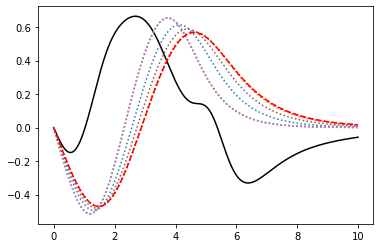

In [307]:
fig = plt.figure()
ax = plt.axes()

isospin = 1
i_s = 0
i_l = 0
i_n = 1

x = np.linspace(0, 20, 2001)
ax.plot(x[:1000],trial_wf[isospin,i_s,i_l,i_n,:1000],color='black')
for i in range(len(train_wfs)):
    ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000],linestyle=":")
ax.plot(x[:1000],test_wf[isospin,i_s,i_l,i_n,:1000],linestyle='--',color='red')

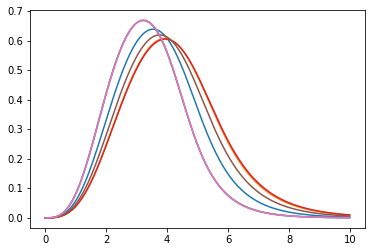

In [304]:
fig = plt.figure()
ax = plt.axes()
train_num = len(train_wfs)
tot_levels = sum(levels)
train = 6
for i in range(train_num):
    for isospin in range(1,2):
        for j in range(5,6):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000])#,linestyle='--',color='red')
            #trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
            #    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]